In [1]:
# Import relevant modules

import numpy as np
from scipy.optimize import curve_fit as fit
from matplotlib import pyplot as plt, ticker as mticker
import time
from scipy.optimize import curve_fit
from scipy.special import wofz
import sys
import pickle

# Import custom modules
import Metropolis as met
import Graphing_Methods as gm

# Useful constants

c = 2.998e8
h = 6.626e-34
e = 1.602e-19
hbar = h / (2 * np.pi)
nm_ev_conv = h * c / (1e-9 * e)

In [2]:
# Load Bayesian fit file

### EDIT HERE ###

direc_load = "C:\\Users\\pcadm\\Documents\\QNP Code\\QNP Code - Copy\\Saved Variables\\UK Sample 2 T Dependence Bayesian Analysis"

fn_load = '5-21-22 6.1 K Analysis, 9-11 peak models, 100000 iterations'

### STOP EDITING HERE ###

load_path = direc_load + '\\' + fn_load + '.pkl'

with open(load_path, 'rb') as file:
      
    # Call load method to deserialze
    bayesian_fit_data = pickle.load(file)

# Unpack the list containing all relevant fit data

bayesian_x = bayesian_fit_data[0]
bayesian_y = bayesian_fit_data[1]
num_iters = bayesian_fit_data[2]
theta_info = bayesian_fit_data[3]
P_D_theta_info = bayesian_fit_data[4]
noise_sig_arr = bayesian_fit_data[5]
F_arrs = bayesian_fit_data[6]
F_indices = bayesian_fit_data[7]
param_means = bayesian_fit_data[8]
param_stds = bayesian_fit_data[9]

In [3]:
### DO NOT EDIT THIS CELL ###

n_lst = [n for n in F_arrs]
nmin = min(n_lst)
nmax = max(n_lst)

In [4]:
### DO NOT EDIT THIS CELL ###

def fano_voigt(x, theta, wavelength_flag = False):
    
    x0 = theta[0]
    if wavelength_flag:
        q = -1 * theta[1]
    else:
        q = theta[1]
    sigma = theta[2]
    FWHM = theta[3]
    height = theta[4]
    offset = theta[5]
    
    mult = height / (q ** 2 + 1)
    
    z = (x - x0 + 1j * FWHM/2) / (np.sqrt(2) * sigma)
    return offset + mult * (1 / (sigma * np.sqrt(2 * np.pi))) * ((q**2 - 1) * np.real(wofz(z)) - 2*q * np.imag(wofz(z)))


def n_peak_model(n, x, params):
    
    E = nm_ev_conv / x
  
    Eg = params[0]
    Ry = params[1]
    sigma = params[2]
    a0 = params[3]
    Eu = params[4]
    offset = params[5]

    output = offset + a0 * np.exp((E - Eg) / Eu)
    for ii in range(n):
        delta = params[6 + 4 * ii]
        FWHM = params[7 + 4 * ii]
        q = params[8 + 4 * ii]
        height = params[9 + 4 * ii]

        En = Eg - Ry / (ii + 2 - delta) ** 2 # Find center energy and convert to wavelength
        lamn = nm_ev_conv / En

        output = output + fano_voigt(x, [lamn, q, sigma, FWHM, height, 0], wavelength_flag = True)
  
    return output

In [5]:
### DO NOT EDIT THIS CELL ###
num_models = nmax - nmin + 1
models_arr = {}

for ii in range(num_models):
    ntemp = nmin + ii
    models_arr[ntemp] = lambda x, theta, nval=ntemp: n_peak_model(nval, x, theta)

In [6]:
### DO NOT EDIT THIS CELL ###
cl = np.array([1000, 2000])
ROI = np.array([np.min(bayesian_x), np.max(bayesian_x)])

params = {}
param_names = {}
param_means = {}
param_stds = {}

# Method to generate a list of parameter names for an n peak model
def gen_param_names(n):
    output = [0] * (6 + 4 * n)
    output[0] = 'Eg'
    output[1] = 'Ry'
    output[2] = 'Std. Dev.'
    output[3] = 'a0'
    output[4] = 'Urbach Energy'
    output[5] = 'Offset'
    for ii in range(n):
        output[6 + 4 * ii] = 'Q. Def. ' + str(ii + 1)
        output[7 + 4 * ii] = 'FWHM ' + str(ii + 1)
        output[8 + 4 * ii] = 'q ' + str(ii + 1)
        output[9 + 4 * ii] = 'Height ' + str(ii + 1)
    
    return output
    
for ii in range(nmin, nmax + 1):
    params[ii] = theta_info[ii][F_indices[ii], :, :]
    param_names[ii] = gen_param_names(ii)
    param_means[ii], param_stds[ii] = met.param_sum(theta_info[ii], F_indices[ii])

# Method to plot histograms of all fit parameters for a given model
def plot_hists():
    n_list = np.array([x for x in range(nmin, nmax + 1)])
        
    for jj in range(6 + 4 * nmax):
        num_plots = np.sum(jj < 6 + 4 * n_list)
        fig, axs = plt.subplots(1, num_plots)
        fig.set_figheight(5)
        fig.set_figwidth(5 * num_plots)
        for kk in range(num_plots):
            if num_plots > 1:
                n_temp = nmax - num_plots + kk + 1
                axs[kk].hist(params[n_temp][num_iters//2::, jj])
                axs[kk].set_title(param_names[n_temp][jj] + ' from ' + str(n_temp) + ' Peak Model')
            else:
                n_temp = nmax - num_plots + kk + 1
                axs.hist(params[n_temp][num_iters//2::, jj])
                axs.set_title(param_names[n_temp][jj] + ' from ' + str(n_temp) + ' Peak Model')

# Function to plot the best fit for each model
def plot_best_fits():
    for ii in range(nmin, nmax + 1):
        best_fit_y = models_arr[ii](bayesian_x, param_means[ii])
        resid_y = bayesian_y - best_fit_y
        gm.plot_data([bayesian_x],
             [bayesian_y],
             [bayesian_x],
             [best_fit_y],
             cutoff_lams = cl, plot_mode = 'multi', xlim = ROI,
             legend_lst = ['Data'],
             screened_legend_lst = [str(ii) + ' Peak Fit'],
             title = 'Plot of Best ' + str(ii) + ' Peak Fit')
        
        gm.plot_data([bayesian_x],
             [resid_y],
             [],
             [],
             cutoff_lams = cl, plot_mode = 'multi', xlim = ROI,
             legend_lst = None,
             screened_legend_lst = None,
             title = 'Plot of Residuals for Best ' + str(ii) + ' Peak Fit')

# Function to list all parameters for each model
def list_params():
    eps = 1e-10
    
    for ii in range(nmin, nmax + 1):
        print(f"{ii} Peak Model")
        print('----------------------------------------------------------')
        print('')
        temp_means = param_means[ii]
        temp_stds = param_stds[ii]
        for jj in range(len(temp_means)):
            power_mean = np.floor(np.log(abs(temp_means[jj]) + eps) / np.log(10))
            power_std = np.floor(np.log(abs(temp_stds[jj]) + eps) / np.log(10))
            power = max(power_mean, power_std)
            if power > -4:
                mean_roundoff = 4
                std_roundoff = 6
            elif power == -4:
                mean_roundoff = 5
                std_roundoff = 7
            else:
                mean_round_off = abs(power) + 1
                std_round_off = abs(power) + 3
            print(f"{param_names[ii][jj]}: {round(temp_means[jj], mean_roundoff)} +/- {round(temp_stds[jj], std_roundoff)}")
        print('')
        print('')

In [15]:
# Function to plot the FWHM on a logarithmic scale for each peak in a
# model (specify which model you want with the best_n argument)
def FWHM_plot(best_n, scale = 'log', normalize = True):
    FWHM_list = np.zeros(best_n)
    FWHM_stds = np.zeros(best_n)
    n_arr = np.zeros(best_n)
    n_cont = np.linspace(2, best_n + 1, 1000)
    for n in range(2, best_n + 2):
        n_arr[n - 2] = n
        FWHM_list[n - 2] = param_means[best_n][7 + 4 * (n - 2)]
        FWHM_stds[n - 2] = param_stds[best_n][7 + 4 * (n - 2)]
    
    if normalize:
        FWHM_stds_plot = FWHM_stds / np.max(FWHM_list)
        FWHM_list_plot = FWHM_list / np.max(FWHM_list)
    else:
        FWHM_stds_plot = FWHM_stds
        FWHM_list_plot = FWHM_list
    
    def Fit_Line(n, A):
        return A / n ** 3
    
    F, _ = curve_fit(Fit_Line, n_arr, FWHM_list_plot)
    A_fit = F[0]
    FWHM_cont = Fit_Line(n_cont, A_fit)
    
    fig, ax = plt.subplots(1,1, figsize = (10,10))
    ax.errorbar(n_arr, FWHM_list_plot, yerr = FWHM_stds_plot, marker = 'o', 
             markerfacecolor = 'red', linestyle = 'none', markersize = 13,
             markeredgecolor = 'red', ecolor = 'red', elinewidth = 2, capsize = 5,
             capthick = 2, label = 'Linewidths')
    ax.plot(n_cont, FWHM_cont, color = 'blue', linestyle = 'dashed', linewidth = 2, label = r"$\propto n^{-3}$")
    ax.set_yscale(scale)
    ax.set_xscale(scale)
    ax.set_xticks([n for n in range(2, best_n + 2)])
    ax.tick_params(axis = 'x', labelsize = 20)
    ax.tick_params(axis = 'y', labelsize = 20)
    
    ax.set_xlabel('n', size = 24)
    ax.set_ylabel('Linewidths (arb.)', size = 24)
    ax.set_title('Yellow Exciton Linewidths', size = 28)
    ax.legend(prop = {'size':24})
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

# Function to plot the oscillator strength on a logarithmic scale for each peak in a
# model (specify which model you want with the best_n argument)
def osc_strength_plot(best_n, scale = 'log', normalize = True):
    osc_strength_list = np.zeros(best_n)
    osc_strength_stds = np.zeros(best_n)
    n_arr = np.zeros(best_n)
    n_cont = np.linspace(2, best_n + 1, 1000)
    for n in range(2, best_n + 2):
        n_arr[n - 2] = n
        osc_strength_list[n - 2] = param_means[best_n][9 + 4 * (n - 2)]
        osc_strength_stds[n - 2] = param_stds[best_n][9 + 4 * (n - 2)]
    
    noise_floor = noise_sig_arr[F_indices[best_n]]
    
    if normalize:
        osc_strength_stds_plot = osc_strength_stds / np.max(osc_strength_list)
        osc_strength_list_plot = osc_strength_list / np.max(osc_strength_list)
        noise_floor = noise_floor / np.max(osc_strength_list)
    else:
        osc_strength_stds_plot = osc_strength_stds
        osc_strength_list_plot = osc_strength_list
    
    def Fit_Line(n, A):
        return A / n ** 3
    
    F, _ = curve_fit(Fit_Line, n_arr, osc_strength_list_plot)
    A_fit = F[0]
    osc_strength_cont = Fit_Line(n_cont, A_fit)
    
    fig, ax = plt.subplots(1,1, figsize = (10,10))
    ax.errorbar(n_arr, osc_strength_list_plot, yerr = osc_strength_stds_plot, marker = 'o', 
             markerfacecolor = 'red', linestyle = 'none', markersize = 13,
             markeredgecolor = 'red', ecolor = 'red', elinewidth = 2, capsize = 5,
             capthick = 2, label = 'Oscillator Strengths')
    ax.plot(n_cont, osc_strength_cont, color = 'blue', linestyle = 'dashed', linewidth = 3.5, label = r"$\propto n^{-3}$")
    #ax.plot([2, best_n + 1], [noise_floor, noise_floor], color = 'orange', linestyle = 'dashed', linewidth = 2)
    
    ax.set_yscale(scale)
    ax.set_xscale(scale)
    ax.set_xticks([n for n in range(2, best_n + 2)])
    ax.tick_params(axis = 'x', labelsize = 20)
    ax.tick_params(axis = 'y', labelsize = 20)
    
    ax.set_xlabel('n', size = 24)
    ax.set_ylabel('Oscillator Strengths (arb.)', size = 24)
    ax.set_title('Yellow Exciton Oscillator Strengths', size = 28)
    ax.legend(prop = {'size':24})
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())

# Function to plot the energies and quantum defects for a given model
def En_q_def_plot(best_n):
    n_arr = np.array([x for x in range(2, best_n + 2)])
    EG = param_means[best_n][0]
    EG_std = param_stds[best_n][0]

    RY = param_means[best_n][1]
    RY_std = param_stds[best_n][1]

    DEFS = np.array([param_means[best_n][6 + 4 * ii] for ii in range(0, best_n)])
    DEFS_std = np.array([param_stds[best_n][6 + 4 * ii] for ii in range(0, best_n)])

    En_arr = np.zeros(best_n)
    En_std = np.zeros(best_n)
    for ii in range(best_n):
        temp = RY / (ii + 2 - DEFS[ii]) ** 2
        temp_std = (RY_std ** 2 / (ii + 2 - DEFS[ii]) ** 4)
        temp_std += 4 * RY ** 2 * (DEFS_std[ii] ** 2) / (ii + 2 - DEFS[ii]) ** 6
        temp_std = np.sqrt(temp_std)
        En_arr[ii] = temp * 1000
        En_std[ii] = temp_std * 1000
    
    n_cont_arr = np.linspace(2, best_n + 1, 1000)
    En_est = (RY / n_cont_arr ** 2) * 1000

    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot(111)
    ax1.plot(n_arr, En_arr, marker = 'o', markerfacecolor = 'none', markeredgewidth = 2,
            linestyle = 'none', markersize = 13, markeredgecolor = 'red', label = r"$E_g - E_n$")
    ax1.plot(n_cont_arr, En_est, color = 'blue', linewidth = 3.5, linestyle = 'dashed',
        label = r"$\propto n^{-2}$")
    plt.errorbar(n_arr, DEFS * 5 / 0.03, yerr = DEFS_std * 5 / 0.03, marker = 'o', 
             markerfacecolor = 'black', linestyle = 'none', markersize = 13,
             markeredgecolor = 'black', ecolor = 'black', elinewidth = 2, capsize = 5,
             capthick = 2, label = 'Quantum Defects')

    ax1.set_xlabel('n', size = 24)
    ax1.set_ylabel('Energy (meV)', size = 24)
    ax1.tick_params(axis='x', labelsize = 20)
    ax1.tick_params(axis='y', labelsize = 20)
    ax1.legend(prop = {'size':20})
    ax1.set_ylim([0, 24.99999])
    ax1.set_title('Yellow Exciton Series Resonance Energies\nand Quantum Defects', size = 28)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Quantum Defect', size = 24, rotation = 270, labelpad = 30)
    ax2.tick_params(axis = 'y', labelsize = 20)
    ax2.set_yticks([0.03, 0.06, 0.09, 0.12])
    ax2.set_ylim([0, 0.1499999])
    
    return ax1



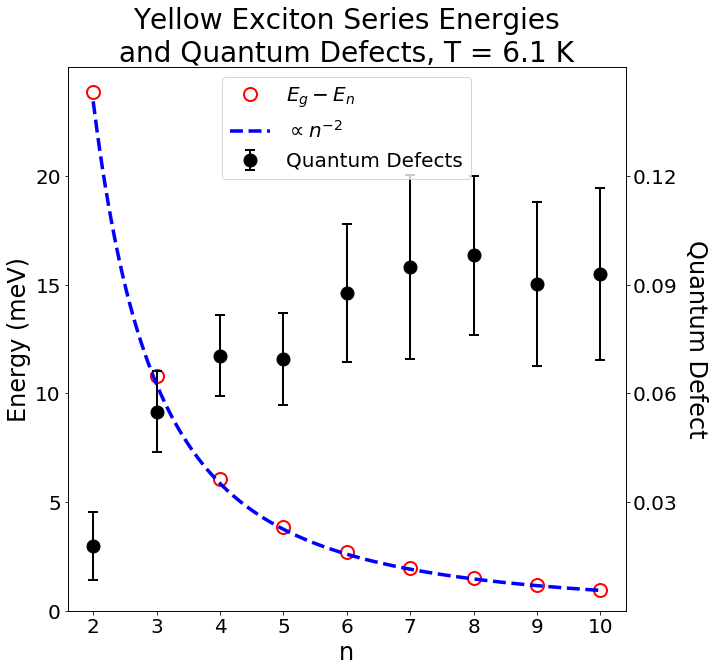

In [16]:
ax1 = En_q_def_plot(9)
ax1.set_title('Yellow Exciton Series Energies\nand Quantum Defects, T = 6.1 K', fontsize = 28)
plt.savefig('C:\\Users\\pcadm\\Documents\\Random Images\\MQC Poster Images\\Quantum Defect and Energy Plot, 6.1 K.png',
           bbox_inches = 'tight')

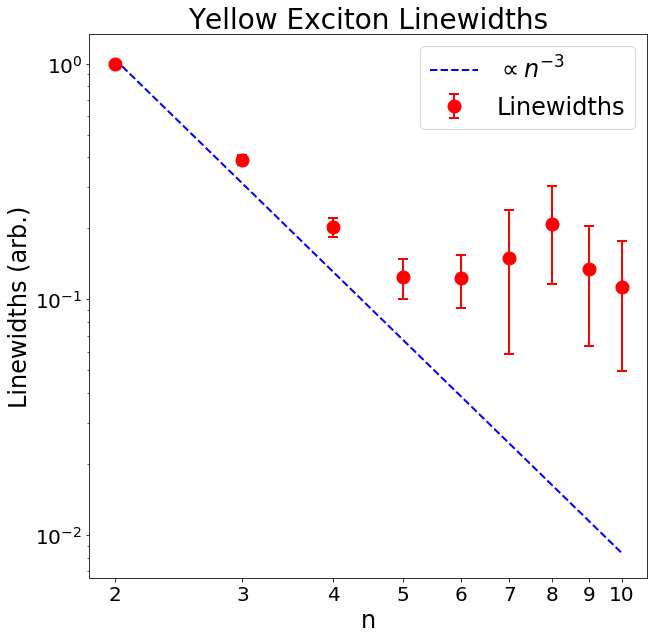

In [9]:
FWHM_plot(9)

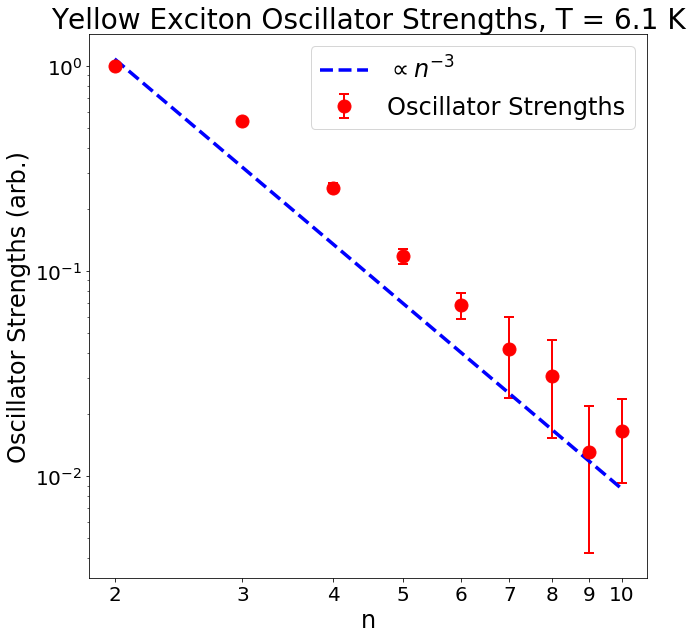

In [17]:
osc_strength_plot(9)
plt.title('Yellow Exciton Oscillator Strengths, T = 6.1 K', fontsize = 28)
plt.savefig('C:\\Users\\pcadm\\Documents\\Random Images\\MQC Poster Images\\Oscillator Strength Plot, 6.1 K.png',
           bbox_inches = 'tight')

(-3286.797304559734, -3217.843514953586)

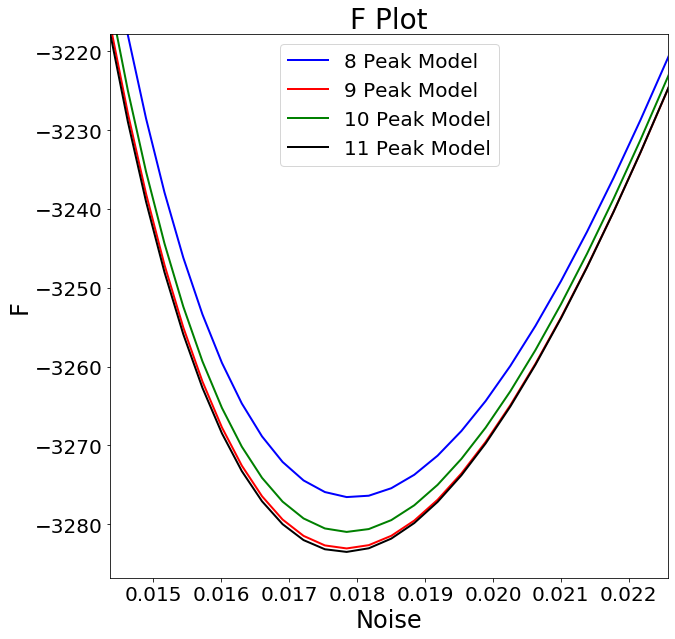

In [11]:
num_replicas = len(noise_sig_arr)

zoom_ratio_high = 0.02
zoom_ratio_low = 0.001
plot_F_min = min([F_arrs[n][F_indices[n]] for n in range(nmin, nmax + 1)])
plot_min = plot_F_min - zoom_ratio_low * abs(plot_F_min)
plot_max = plot_F_min + zoom_ratio_high * abs(plot_F_min)

def checker(idx, compare_val):
    flag_out = True
    for n in F_arrs:
        flag_out *= (F_arrs[n][idx] < compare_val)
  
    return flag_out

plot_max_idx = 0
while not checker(plot_max_idx, plot_max) and plot_max_idx < num_replicas - 1:
    plot_max_idx += 1

plot_min_idx = plot_max_idx

while checker(plot_min_idx, plot_max) and plot_min_idx < num_replicas - 1:
    plot_min_idx += 1
    
plot_x_min = noise_sig_arr[plot_min_idx]
plot_x_max = noise_sig_arr[plot_max_idx]

c_arr = ['blue', 'red', 'green', 'black', 'magenta']
plt.figure(figsize = (10, 10))
for ii in range(num_models):
    plt.plot(noise_sig_arr, F_arrs[nmin + ii], color = c_arr[ii], linewidth = 2,
               label = str(nmin + ii) + ' Peak Model')

plt.xlabel('Noise', size = 24)
plt.ylabel('F', size = 24)
plt.title('F Plot', size = 28)
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.legend(prop = {'size':20})
plt.xlim([plot_x_min, plot_x_max])
plt.ylim([plot_min, plot_max])
#plt.xlim([0.01, 0.03])
#plt.ylim([-3171, -3130])

# If you wish to adjust the zoom on the plot, please do so with comands below
# point. Modifying the code above will mess with the auto-zoom.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


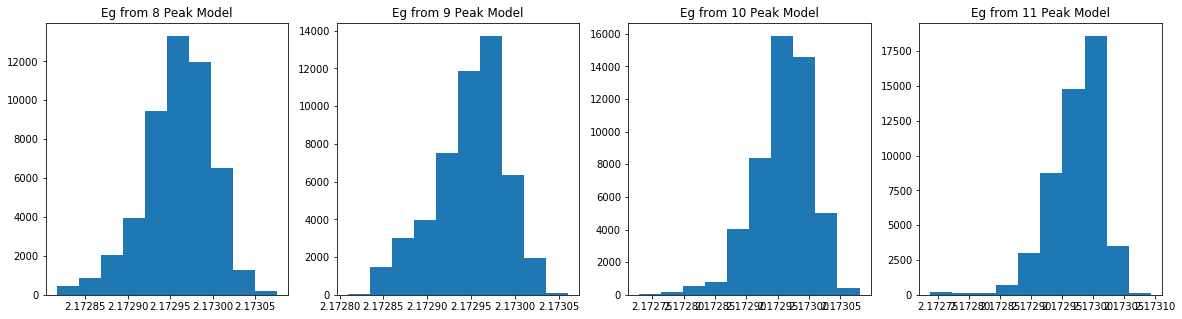

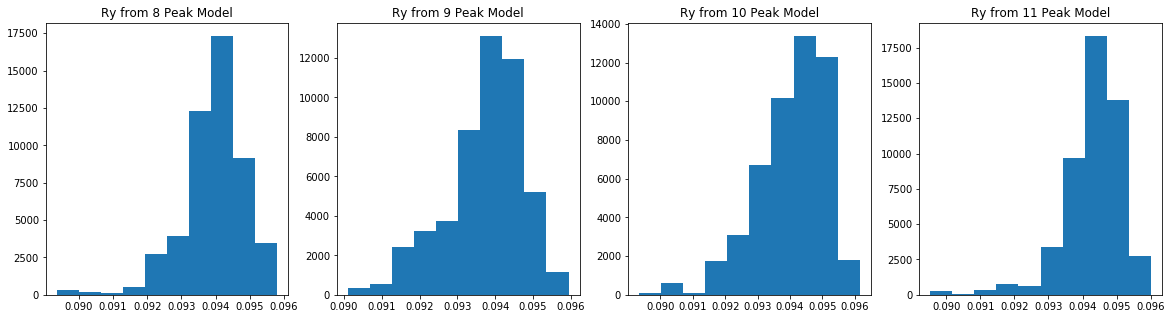

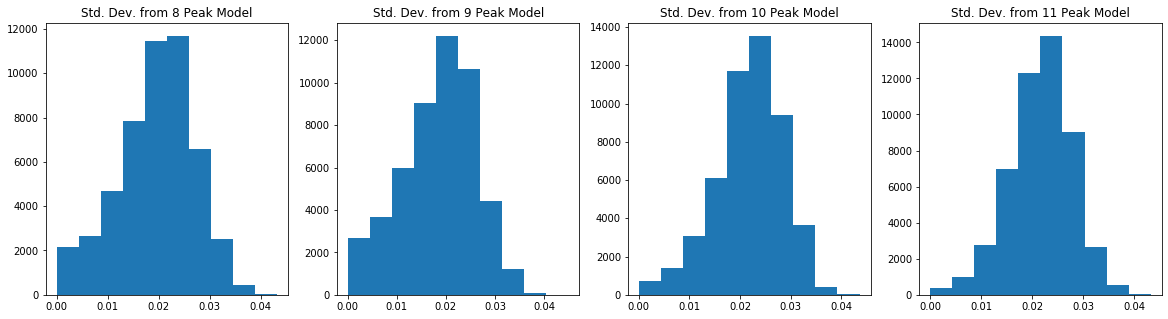

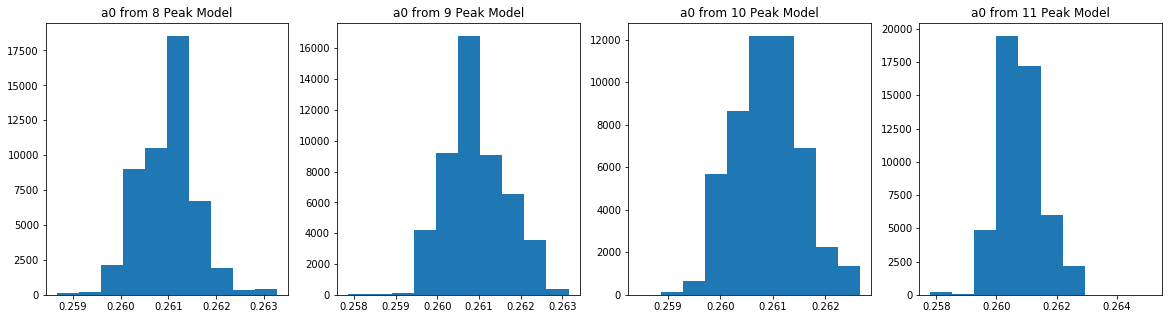

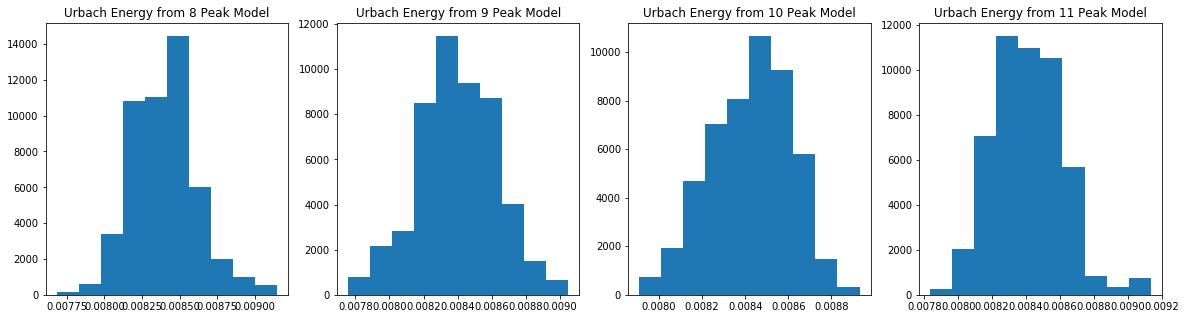

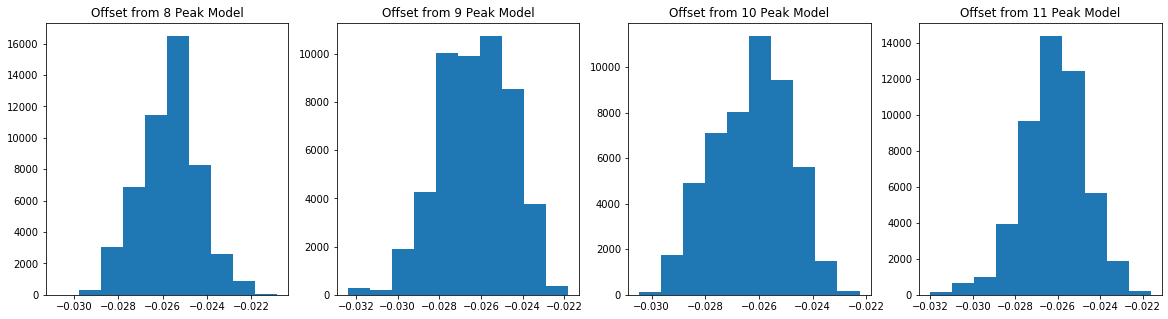

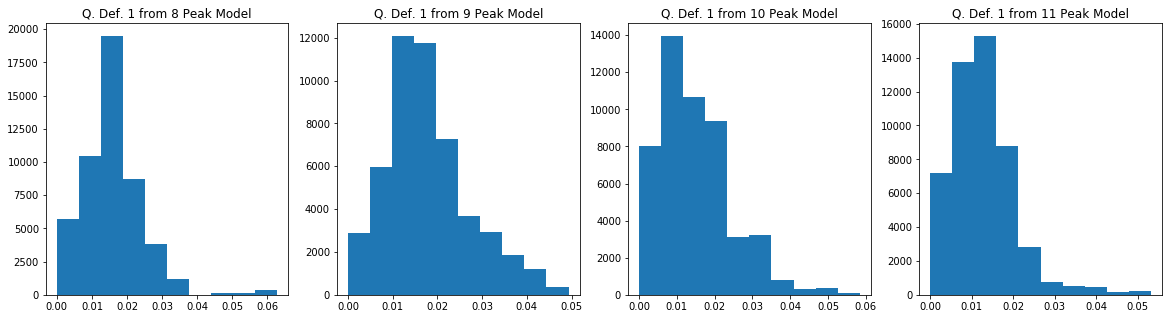

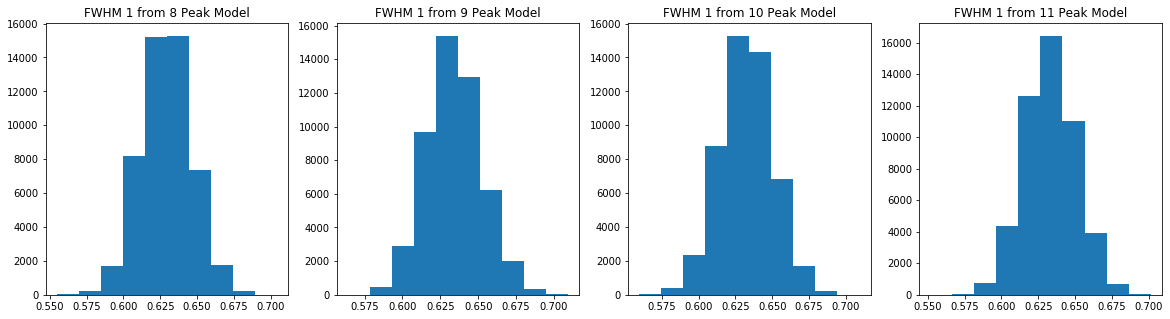

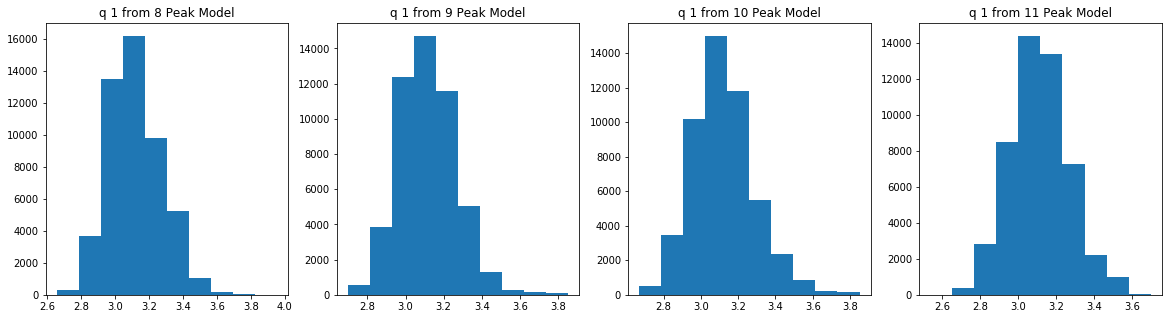

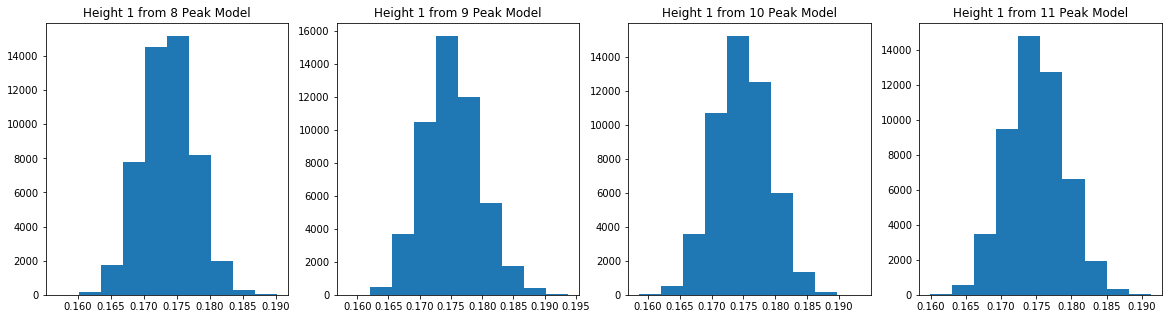

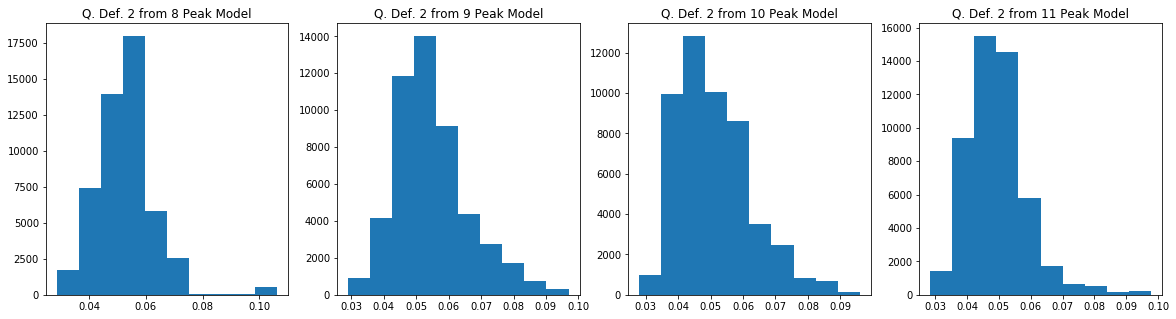

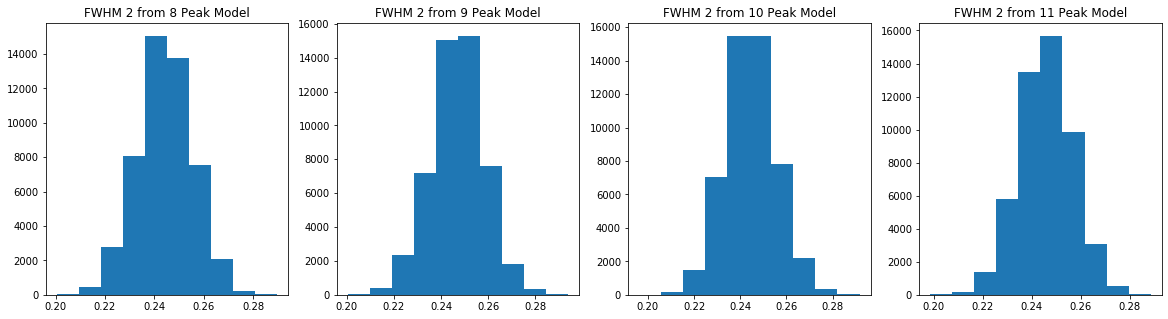

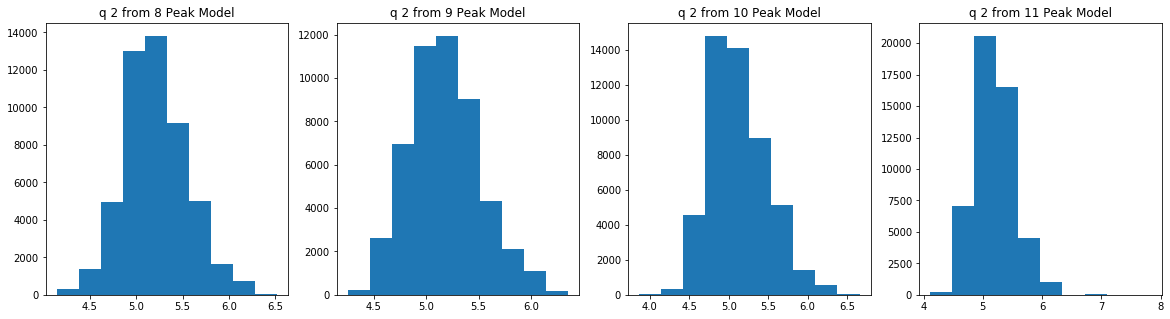

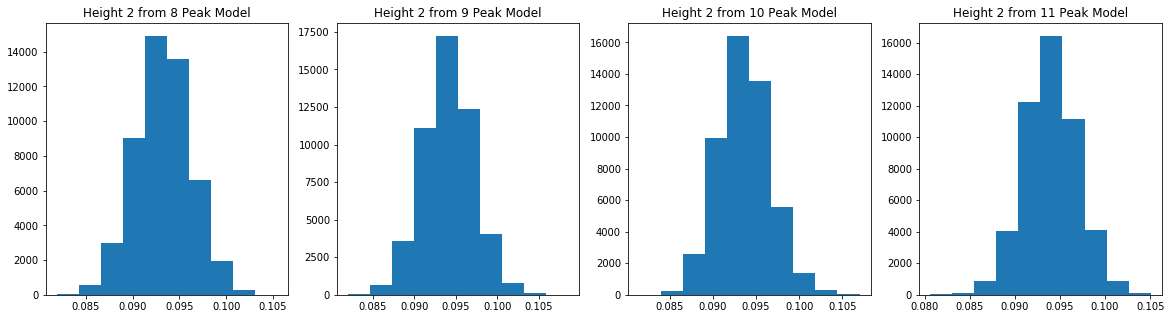

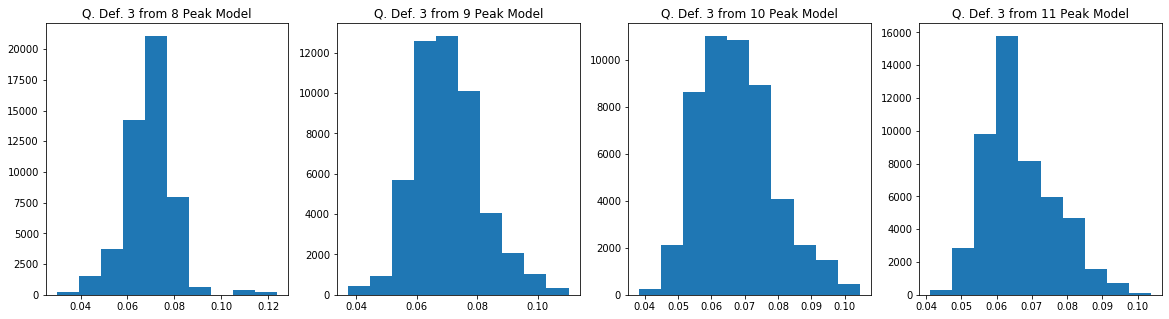

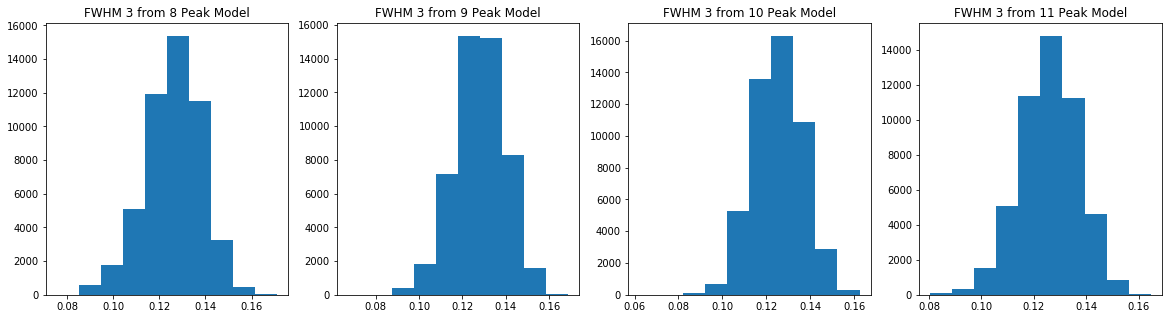

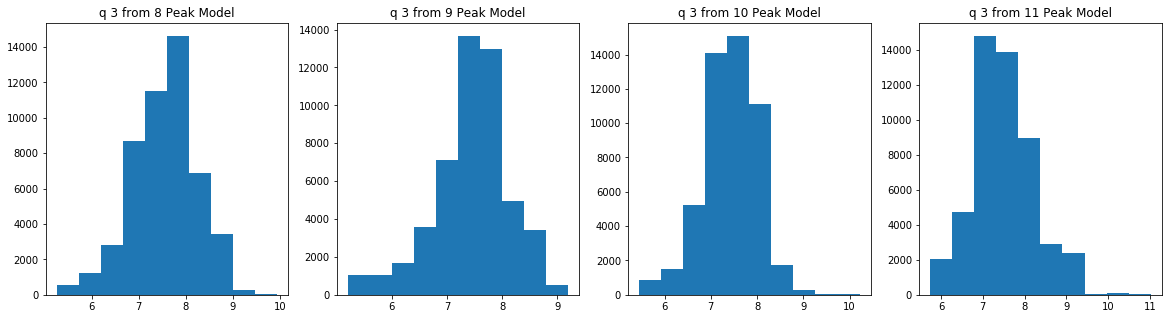

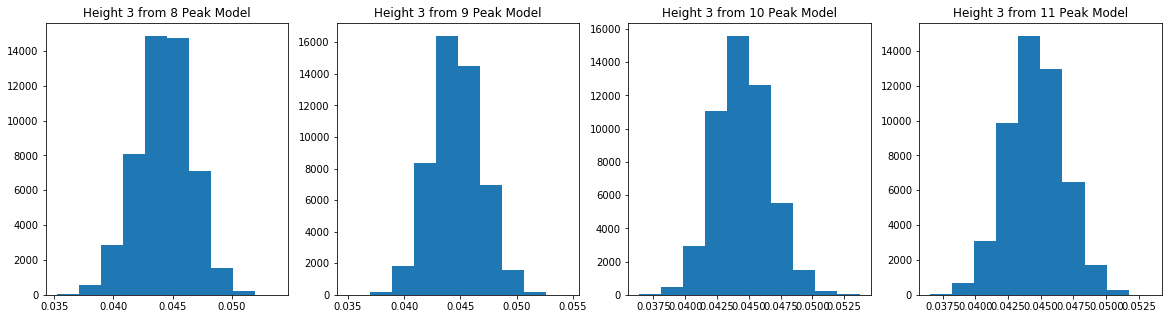

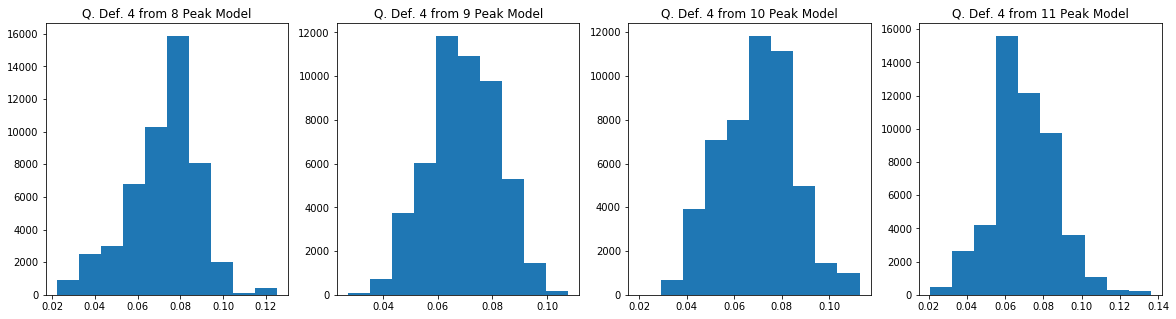

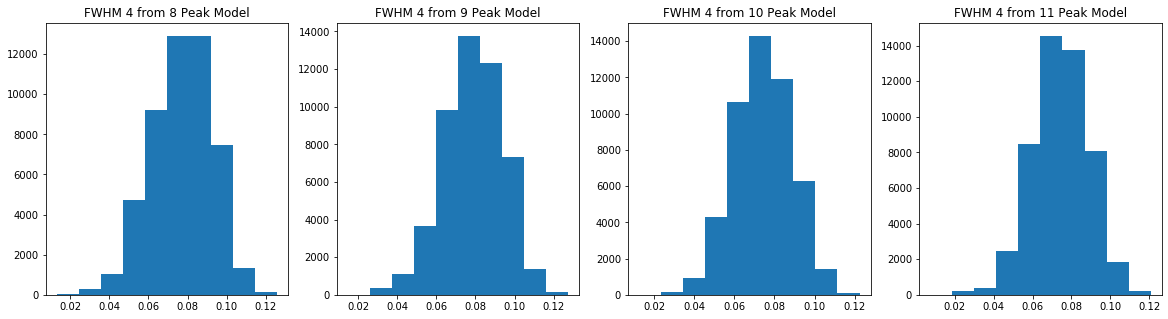

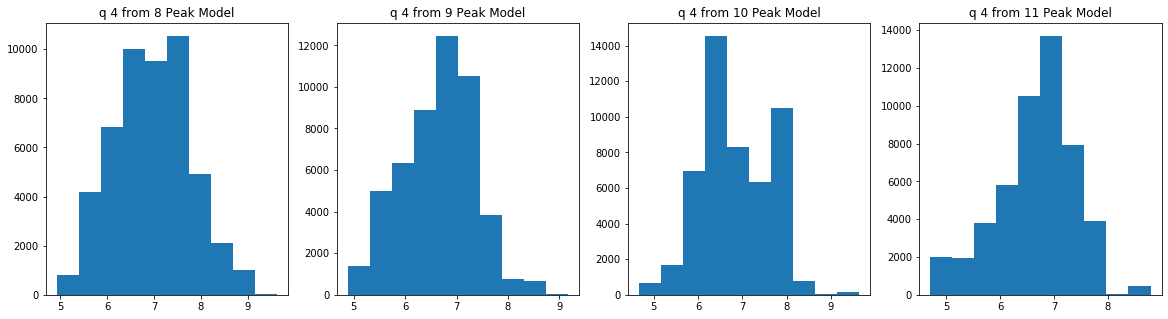

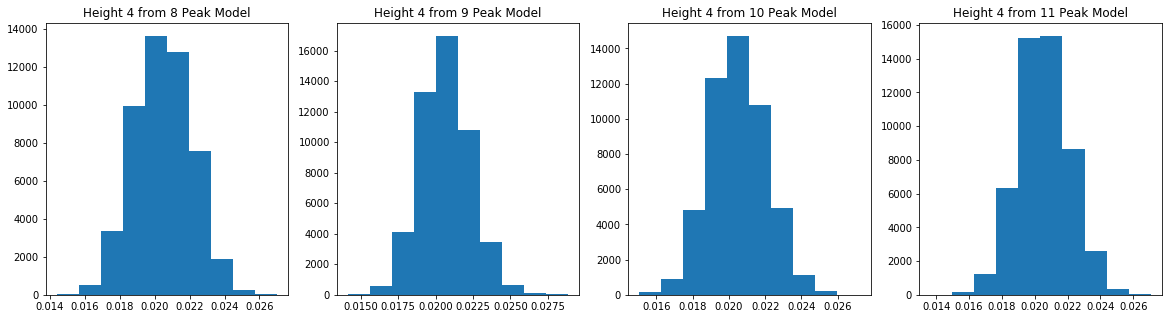

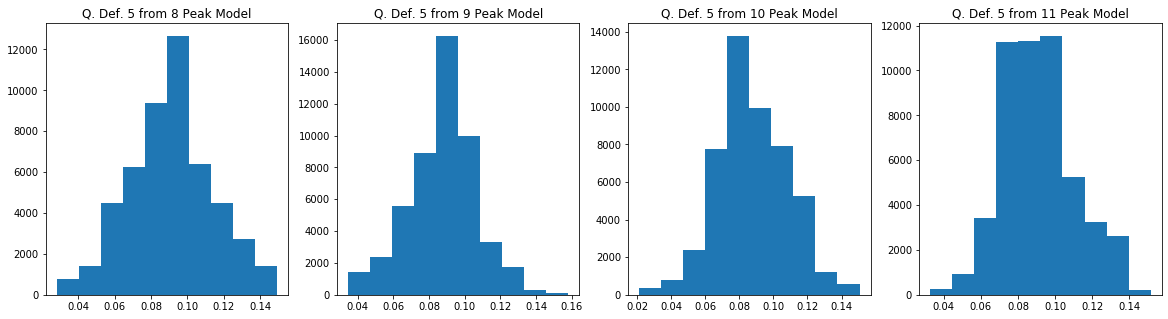

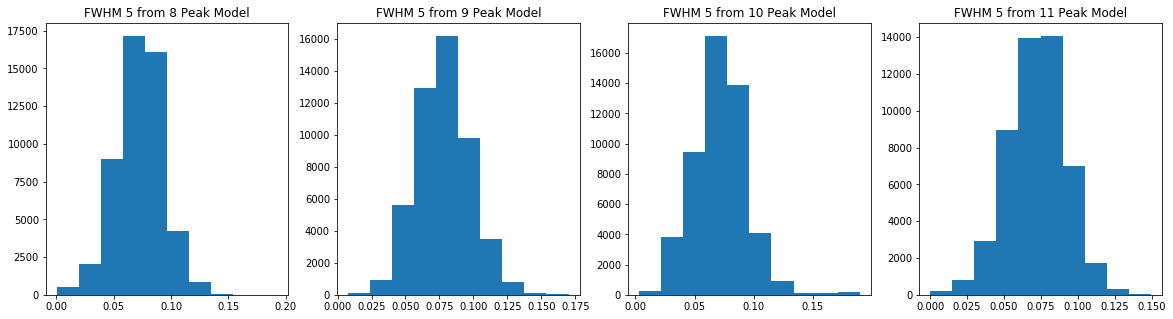

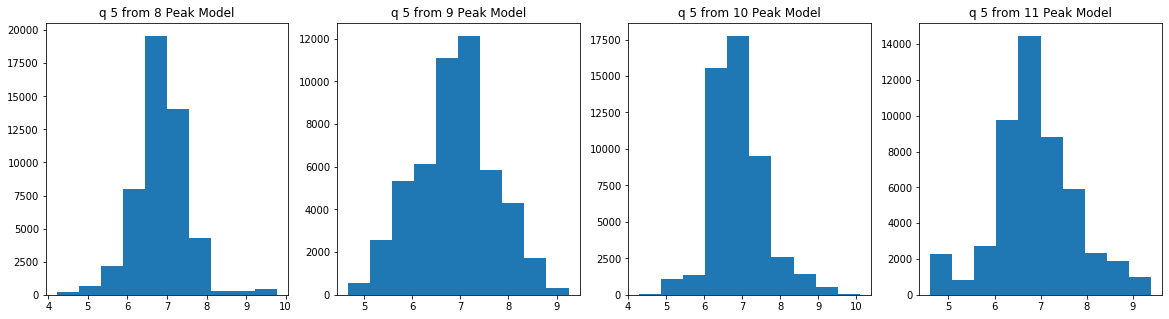

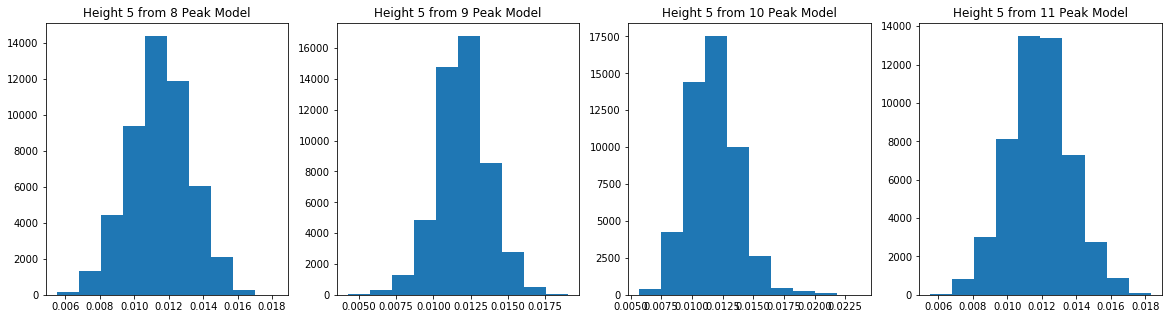

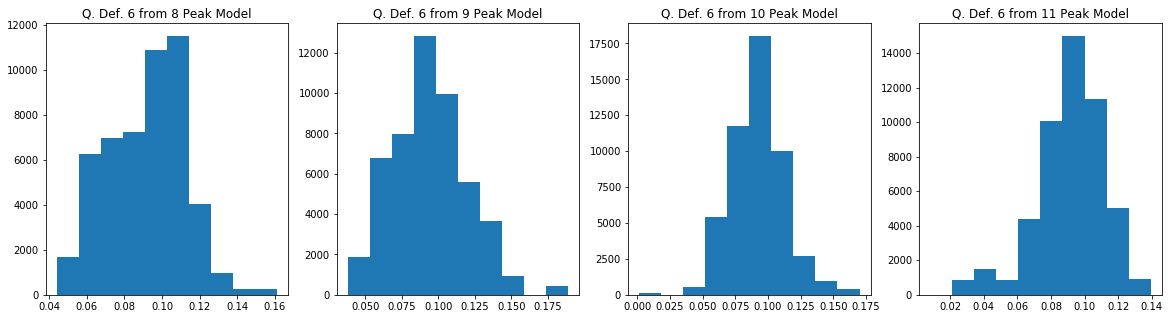

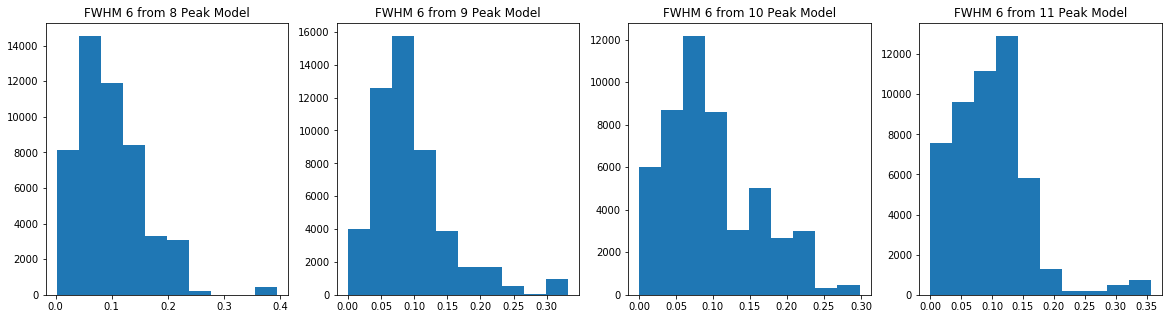

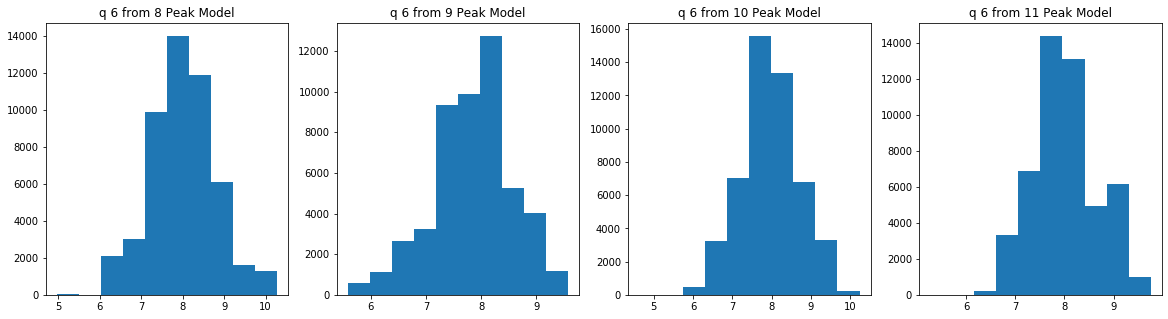

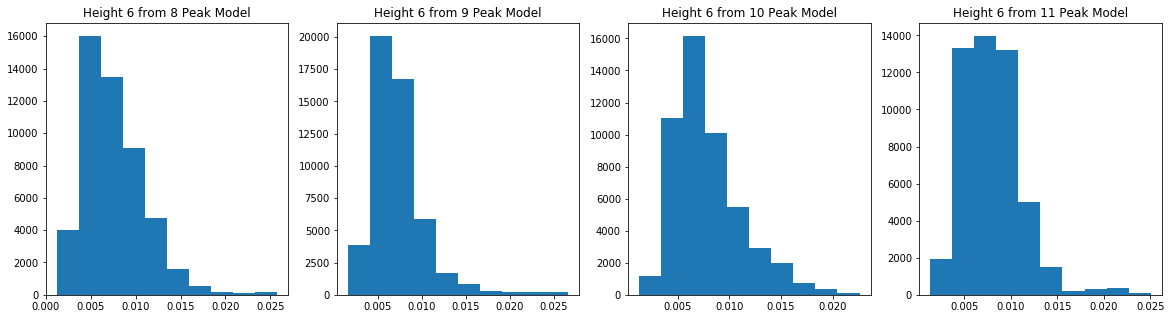

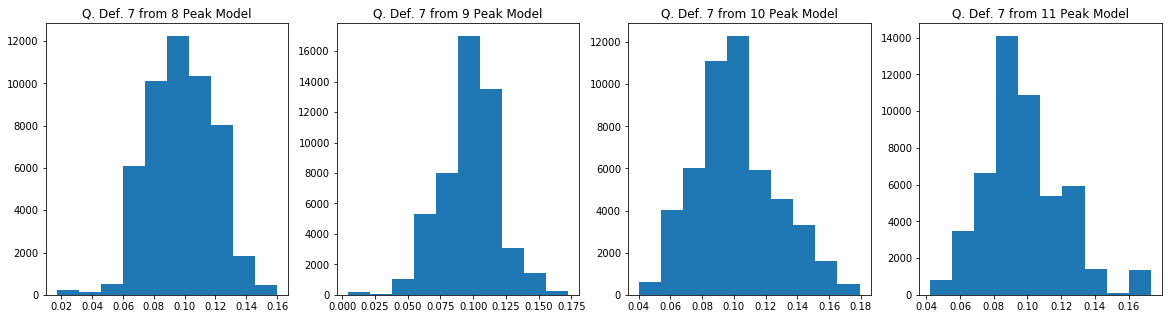

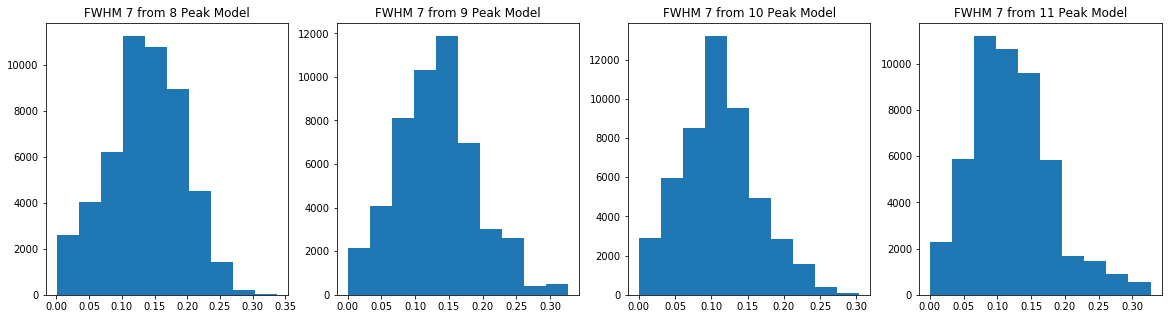

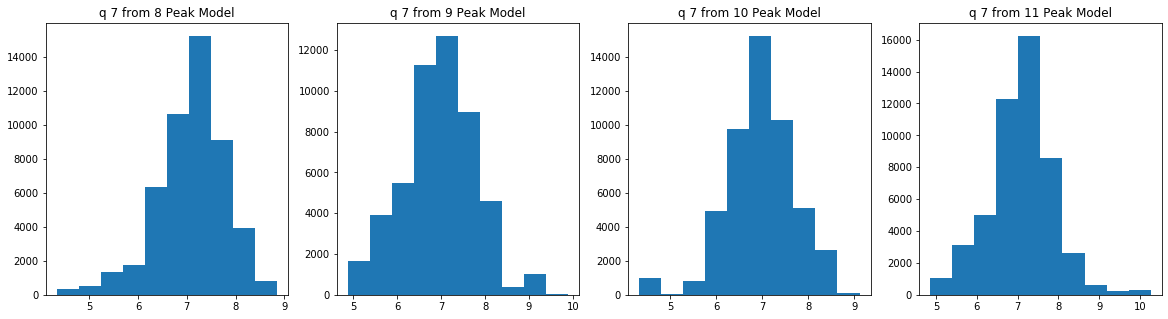

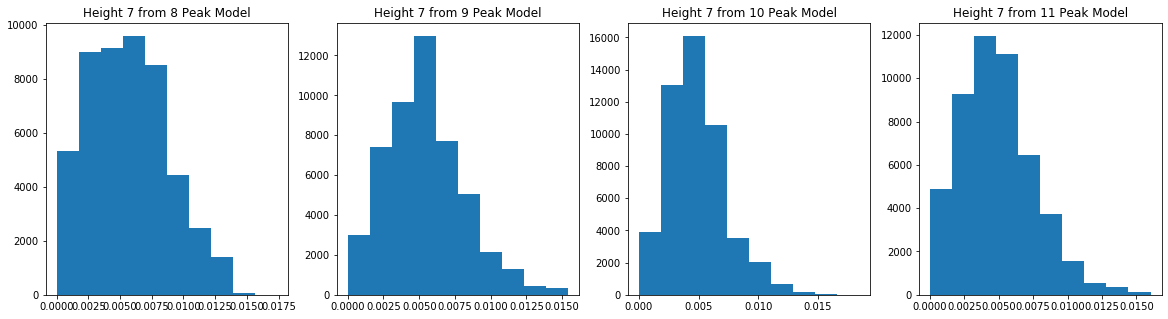

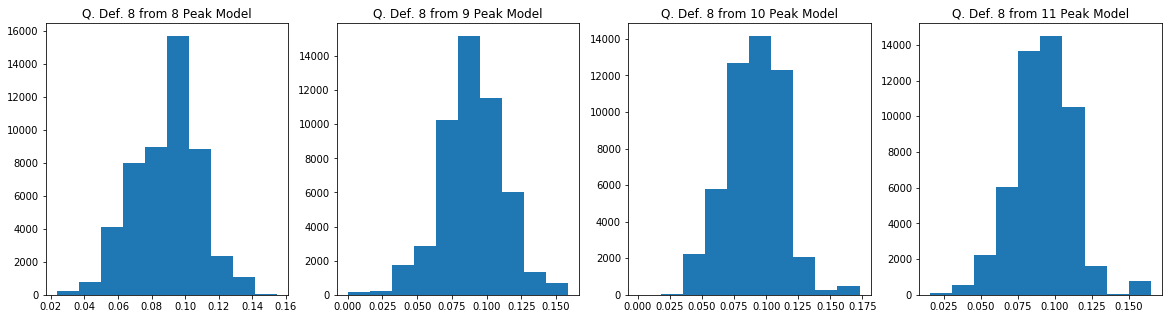

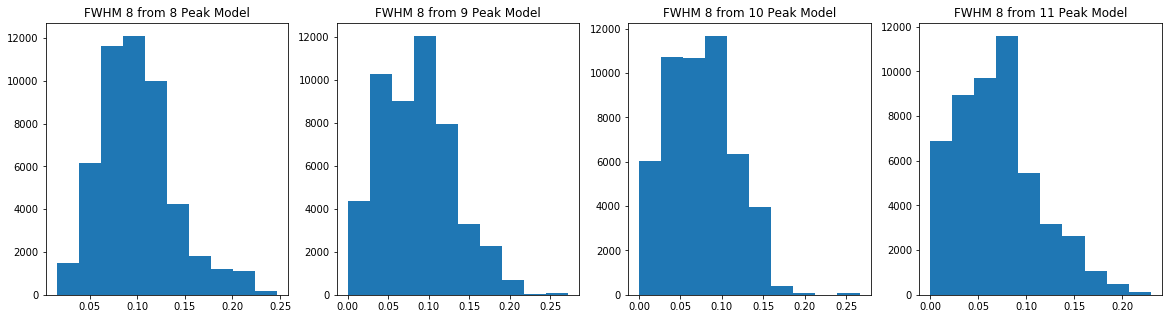

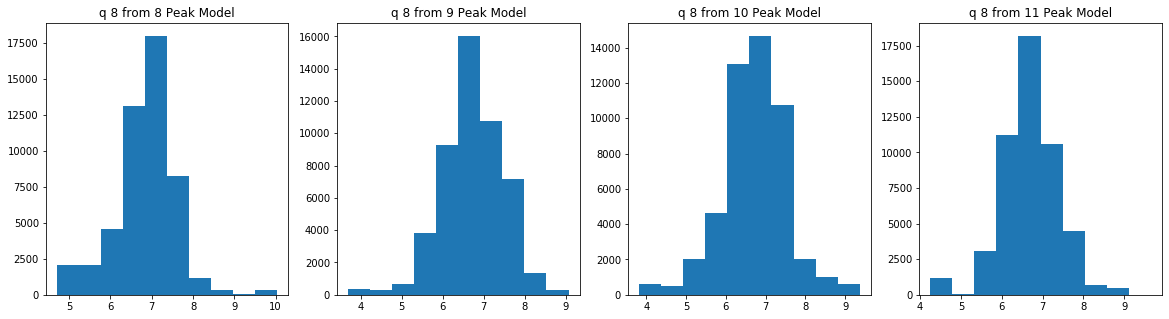

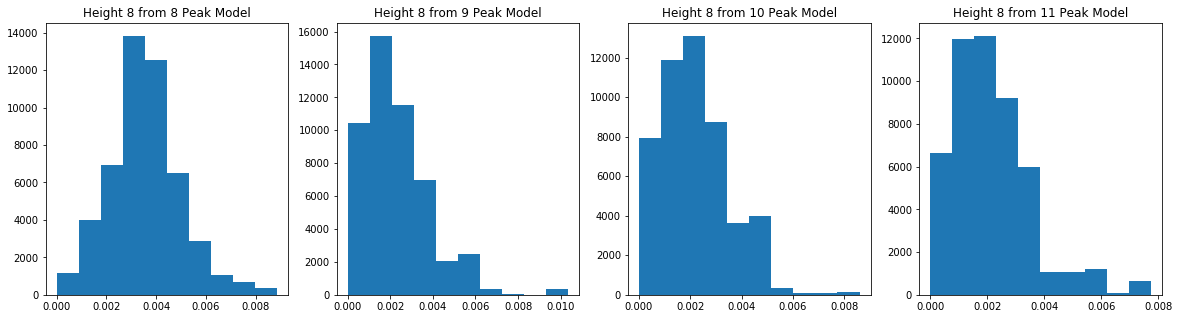

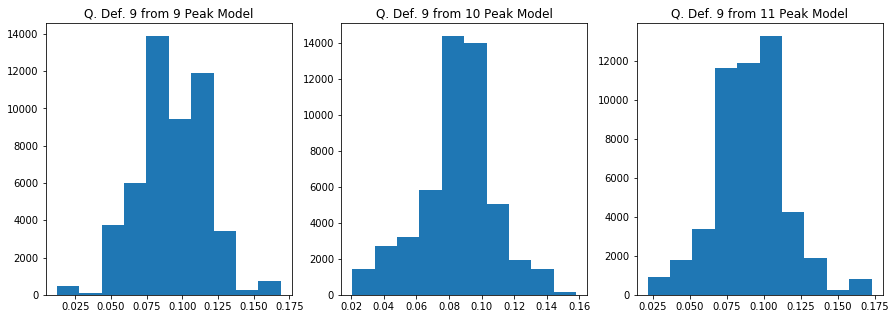

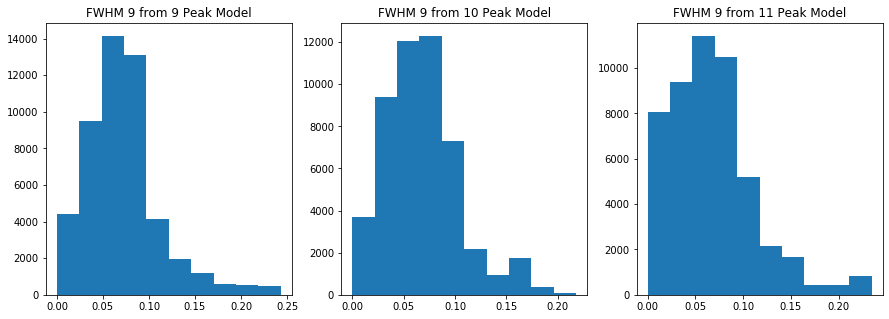

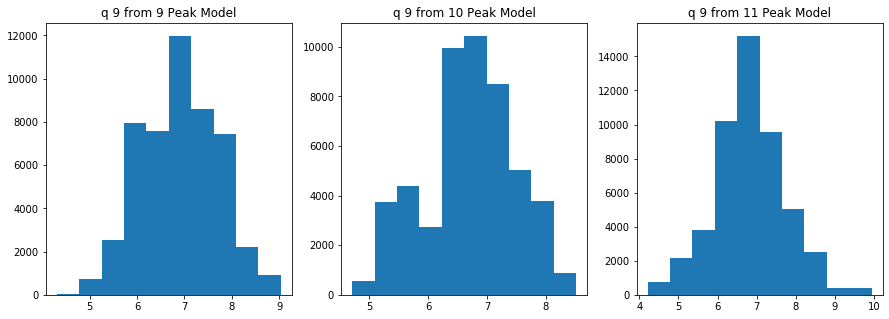

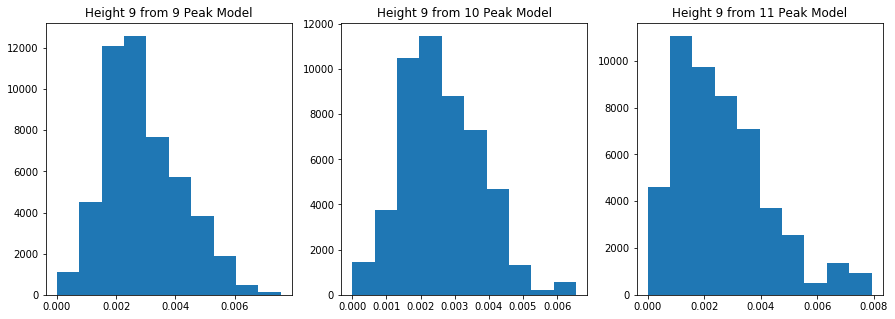

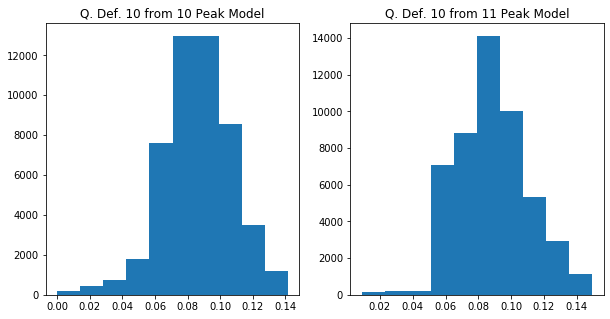

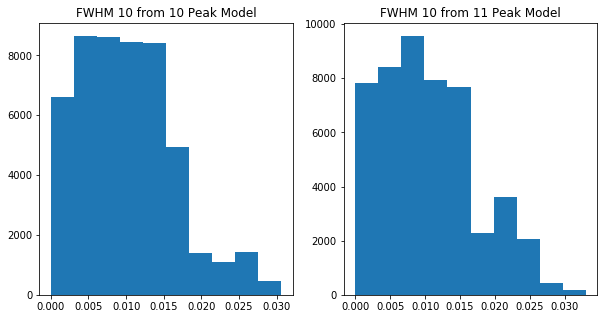

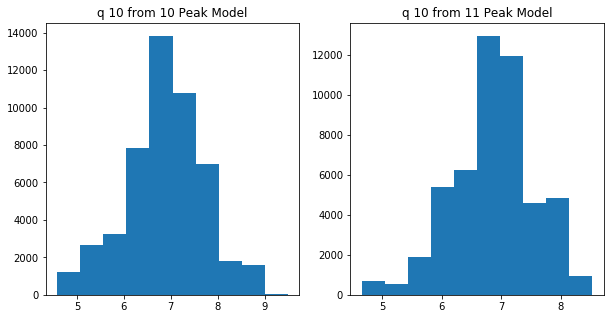

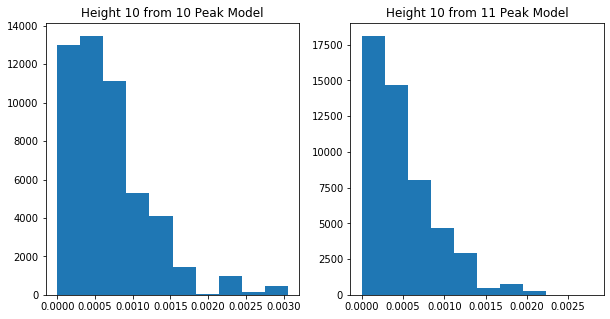

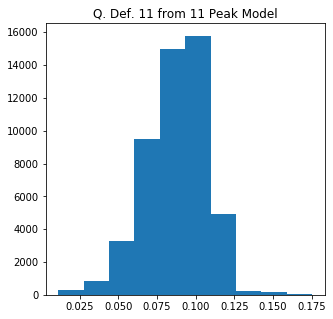

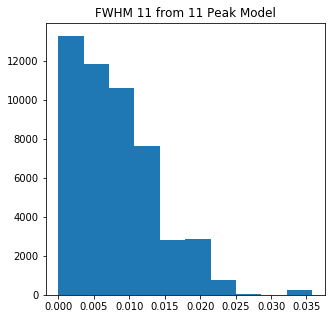

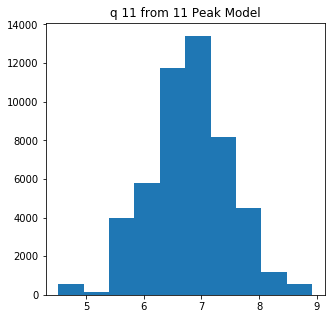

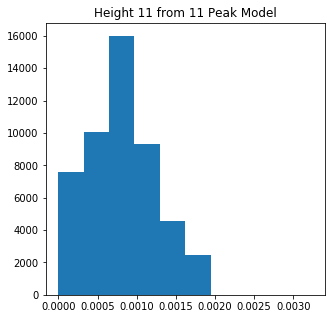

In [12]:
plot_hists()

In [13]:
list_params()

8 Peak Model
----------------------------------------------------------

Eg: 2.173 +/- 4e-05
Ry: 0.094 +/- 0.0009
Std. Dev.: 0.0195 +/- 0.007503
a0: 0.261 +/- 0.000596
Urbach Energy: 0.0084 +/- 0.000215
Offset: -0.0257 +/- 0.001321
Q. Def. 1: 0.0159 +/- 0.008538
FWHM 1: 0.6292 +/- 0.017268
q 1: 3.1186 +/- 0.154785
Height 1: 0.1737 +/- 0.00396
Q. Def. 2: 0.0529 +/- 0.010088
FWHM 2: 0.2445 +/- 0.011105
q 2: 5.2095 +/- 0.337474
Height 2: 0.0933 +/- 0.00298
Q. Def. 3: 0.0694 +/- 0.010539
FWHM 3: 0.1262 +/- 0.012077
q 3: 7.5469 +/- 0.684642
Height 3: 0.0443 +/- 0.002269
Q. Def. 4: 0.0722 +/- 0.016436
FWHM 4: 0.0772 +/- 0.015395
q 4: 6.961 +/- 0.819662
Height 4: 0.0205 +/- 0.00164
Q. Def. 5: 0.0911 +/- 0.022828
FWHM 5: 0.0728 +/- 0.020522
q 5: 6.8737 +/- 0.668239
Height 5: 0.0115 +/- 0.001764
Q. Def. 6: 0.0916 +/- 0.020829
FWHM 6: 0.0987 +/- 0.06083
q 6: 8.0184 +/- 0.782029
Height 6: 0.0076 +/- 0.003402
Q. Def. 7: 0.0979 +/- 0.021031
FWHM 7: 0.1354 +/- 0.057683
q 7: 7.1034 +/- 0.70024
Height

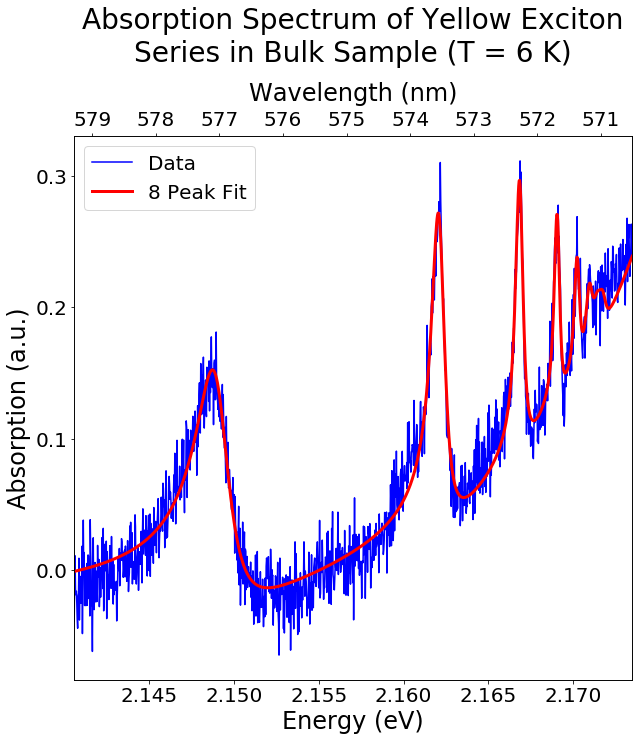

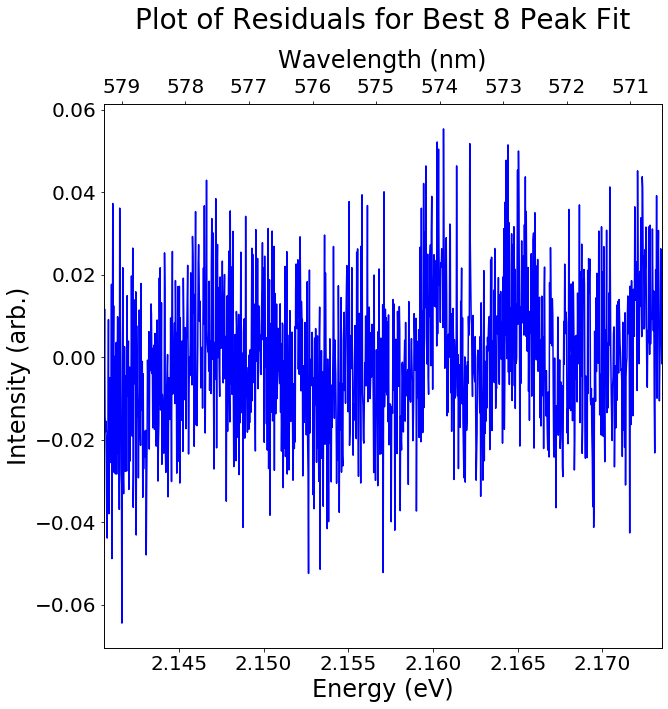

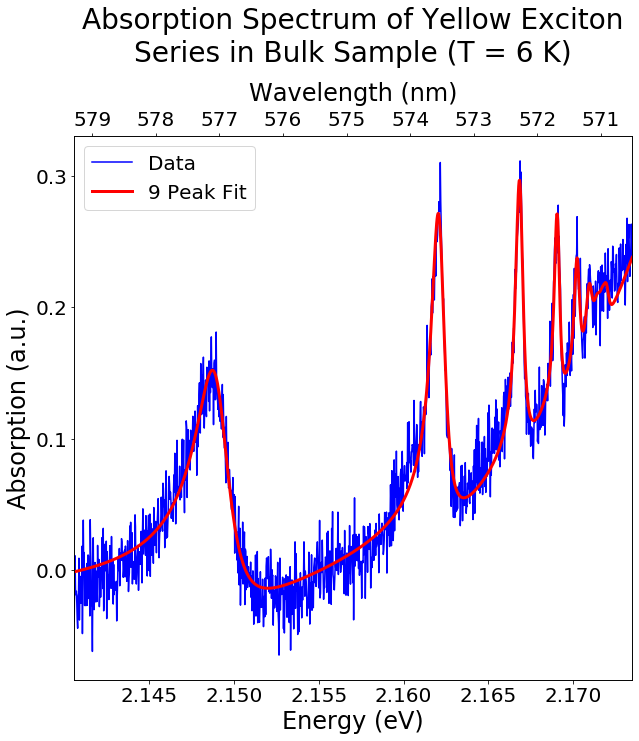

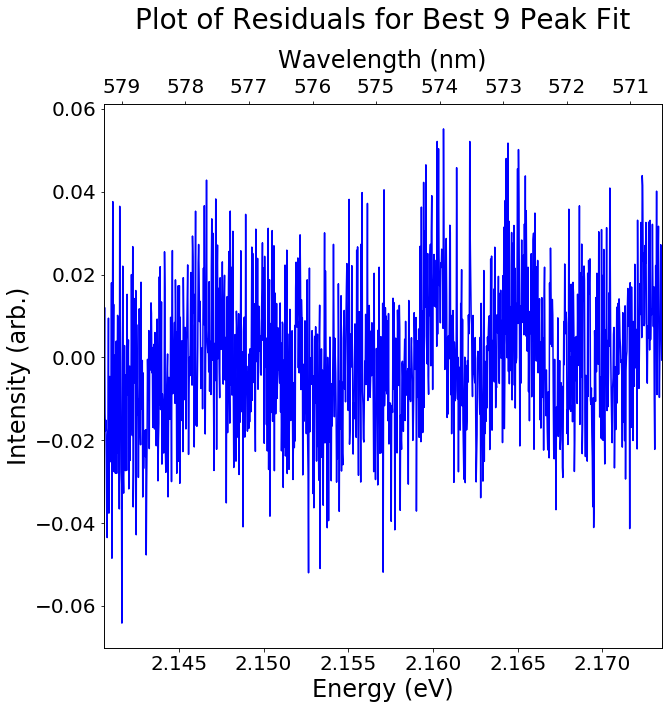

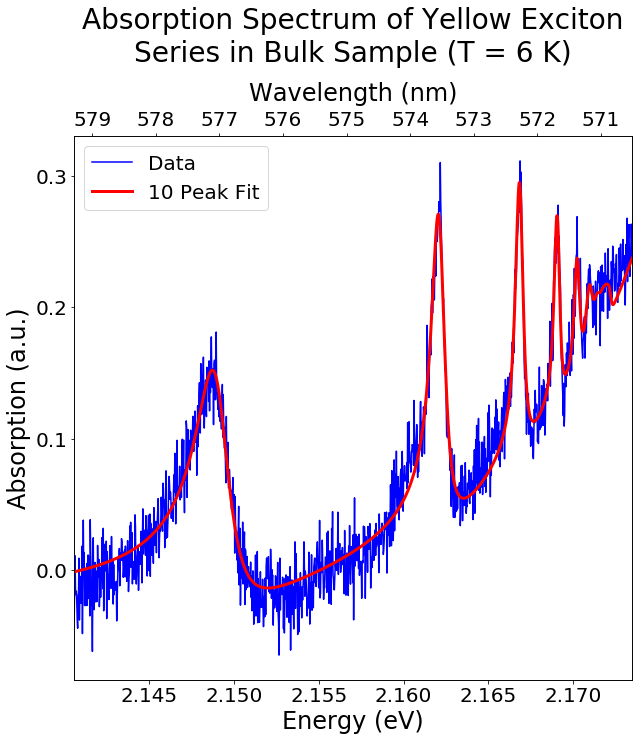

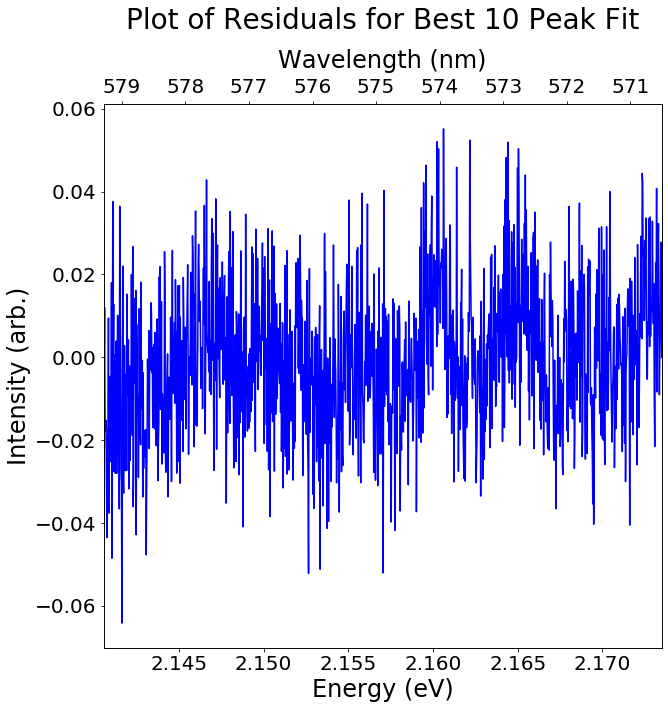

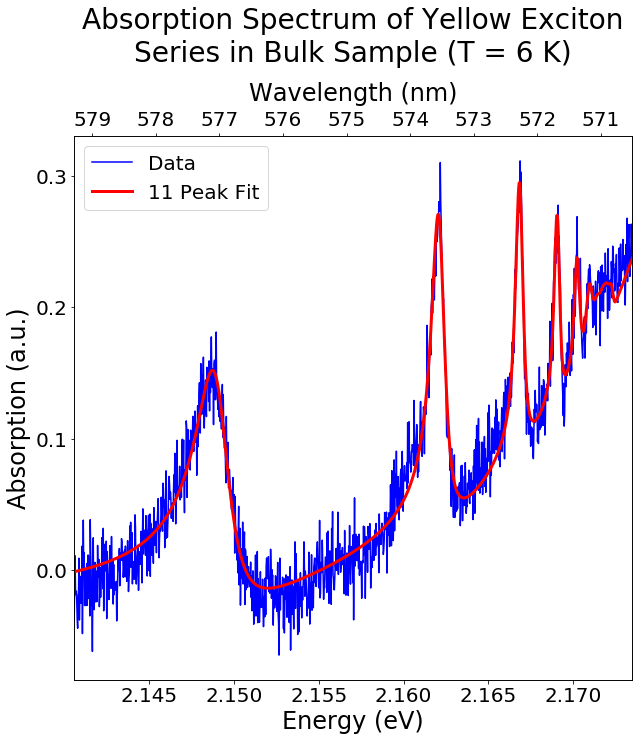

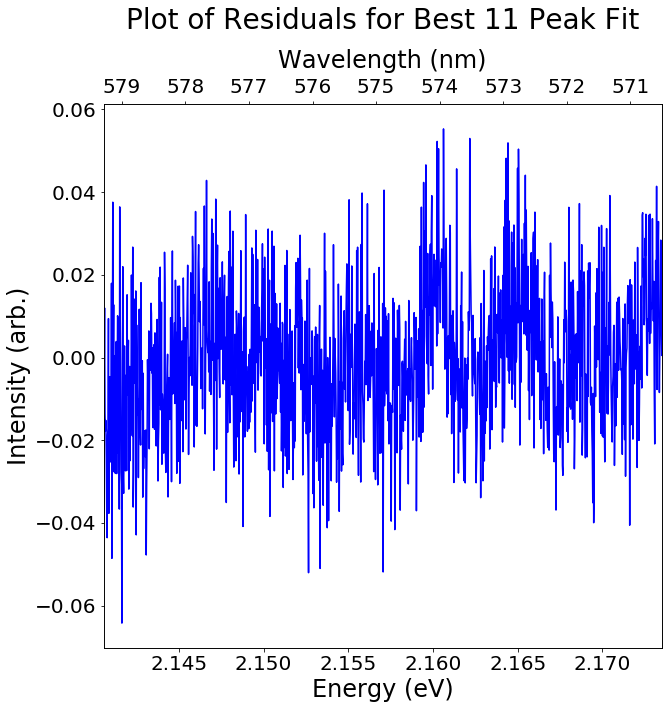

In [14]:
plot_best_fits()

### If you wish to save the params and stds only into a separate file, you can do that here

### START EDITING HERE ###

save_flag = False # Set to True if you want to save

direc_save = 'C:\\Users\\pcadm\\Documents\\QNP Code\\QNP Code - Copy\\Saved Variables\\UK Sample 2 T Dependence Bayesian Analysis'

fn_save = '50 K Params and Stds'

### STOP EDITING HERE ###

pickle_list = [param_means, param_stds]
save_path = direc_save + '\\' + fn_save + '.pkl'

if save_flag:
    with open(save_path, 'wb') as file:
        pickle.dump(pickle_list, file)